# Test python version of balanced PR curves

## rpy2 testing

In [1]:
%load_ext rpy2.ipython

In [2]:
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

In [3]:
%%R -i x,y -o slope,intercept

model <- lm(y ~ x)
slope <- coef(model)[2]
intercept <- coef(model)[1]
print(paste("The slope is", slope, "and the intercept is", intercept))

[1] "The slope is 2 and the intercept is 0"


## yogiroc R version

From https://github.com/jweile/yogiroc

R[write to console]: data.table 1.15.2 using 192 threads (see ?getDTthreads).  
R[write to console]: Latest news: r-datatable.com



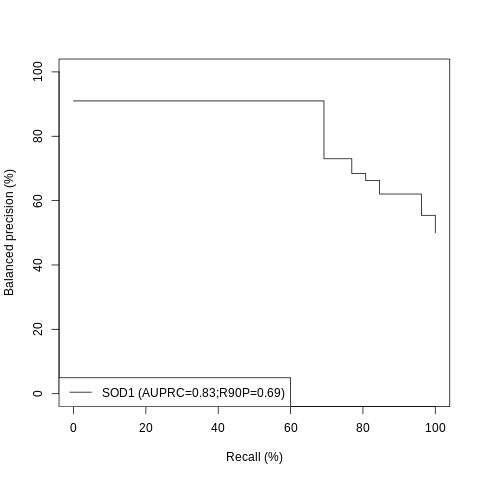

In [4]:
%%R

#load library
library(yogiroc)
library(data.table)

# -------------------------------------------------------------------------
# 1) Obtain scores and reference set (annotated patho. and bengin variants)
# -------------------------------------------------------------------------

FunctionalScores<-fread("SOD1.csv")
FunctionalScores <- FunctionalScores[, .(hgvs_pro, score)]
#FunctionalScores$duplicate<-FunctionalScores$score # Example of additional dataset
FunctionalScores$score <- FunctionalScores$score *-1
#FunctionalScores$duplicate <- FunctionalScores$duplicate*-1

ReferenceSet<-fread("referenceSet.csv")
ReferenceSet[, Pathogenic := ifelse(referenceSet == "Negative", FALSE, TRUE)]

prcdata<-merge(FunctionalScores, ReferenceSet, by = "hgvs_pro")
prcdata <- prcdata[, .(Pathogenic, score)]
prcdata<-na.omit(prcdata)

names(prcdata)[2] <- "SOD1" 
#names(prcdata)[3] <- "SOD1"  #Add curve for additional dataset like this

#create yogiroc objects for the predictions in the data
yrobj <- yr2(truth=prcdata$Pathogenic,scores=prcdata[,-1])

#Automatically saves plot into folder with indicated name
# pdf(file="/Users/warrenvanloggerenberg/Desktop/test.pdf", width=5.5, height=5.5)

#draw the PRC curve(s)
draw.prc(yrobj, balanced=TRUE, main="")

write.csv(prcdata, "prcdata.csv", quote=FALSE, row.names=FALSE)

## Python implementation of yogiroc

In [ ]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(1, "python/")
from yogiroc import *

Sampling PRC paths: 100%|██████████| 128/128 [00:00<00:00, 6596.84it/s]


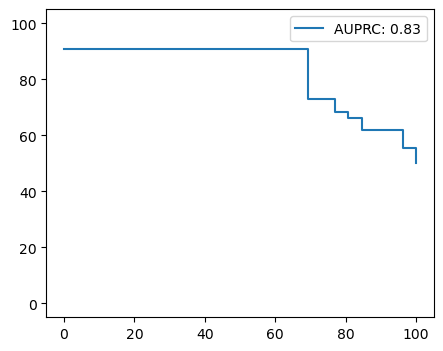

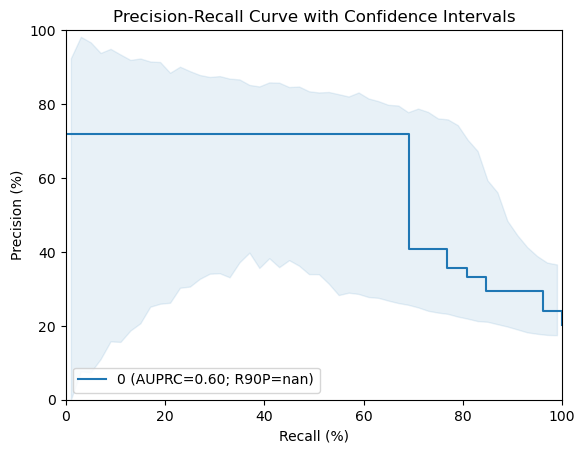

In [17]:
# Generate fake data
scores = pd.read_csv("prcdata.csv", header=0)
scores

# Create YogiROC2 object
# yroc_obj = YogiROC2(scores["Pathogenic"].values, scores["SOD1"].values)

# # Draw ROC and PRC curves
# draw_roc(yroc_obj)
yrobj = YogiROC2(scores["Pathogenic"].values, scores["SOD1"].values)
# Get the performance table from the YogiROC2 object.
table = yrobj.tables[0]
# Compute adjusted (balanced and monotonized) precision.
adj_precision = configure_prec(table, monotonized_flag=True, balanced_flag=True)
# Compute adjusted AUPRC (area under the PR curve).
ap = calc_auc(table["tpr_sens"].values, adj_precision)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(100 * table["tpr_sens"], 100 * adj_precision,
        label=f"AUPRC: {ap:.2f}")
ax.legend()
ylim = ax.set_ylim(-5,105)
# Plot the adjusted PR curve.
# axes[m_idx].plot(100 * table["tpr_sens"], 100 * adj_precision,
#                     label=f"{cat} AP: {ap:.2f}",
#                     color=set2_palette[plddt_cats.index(cat)])
# # Plot chance level as a horizontal dashed line.
# prior = table.iloc[0]["tp"] / (table.iloc[0]["tp"] + table.iloc[0]["fp"])
# axes[m_idx].axhline(y=100 * prior,
#                     color=set2_palette[plddt_cats.index(cat)], ls="--")

#     # Sample PRC paths using the new sample_prcs() function.
#     random_paths = sample_prcs(table)
#     # Infer confidence intervals for the PR curve.
#     ci_df = infer_prc_CI(random_paths, nbins=50)
#     # (Optional: you could adjust the CI columns using balance_prec if desired.)
#     axes[m_idx].fill_between(100 * ci_df["recall"],
#                              100 * ci_df["0.025"],
#                              100 * ci_df["0.975"],
#                              color=set2_palette[plddt_cats.index(cat)],
#                              alpha=0.1)

yroc_obj = YogiROC2(scores["Pathogenic"].values, scores["SOD1"].values)
# draw_prc(yroc_obj, balanced_flag=True, monotonized_flag=True)
draw_prc_CI(yroc_obj, sampling="accurate")

# # Compute AUROC and AUPRC
# print("AUROC:", auroc(yroc_obj))
# print("AUPRC:", auprc(yroc_obj))
# print("Recall at 90% Precision:", recall_at_prec(yroc_obj))

# # Assess significance against random guessing
# pvals_random = auprc_pvrandom(yroc_obj, cycles=1000)  # using fewer cycles for speed
# print("AUPRC p-values vs. random:", pvals_random)

### Results matched up! All good to go.